In [4]:
import numpy as np
import untangle
from xml.etree.ElementTree import ElementTree
from io import BytesIO
import matplotlib.pyplot as plt

# 5 - Bulk Analysis of cell tracks 

In this notebook we will use a combination of detected spots from Mastodon and Masks from labkit in order to choose regions of interest. 

Moreover, we will also be able to edit files from Mastodon in order to be able to observe cell tracks we choose in the user interface of BigDataViewer with Mastodon. 

## Folder and data paths
In the next cell, you need to specify:
- ``path_xml``: Path and file name of the .xml file obtained from converting the data to HDF5/XML is stored.
- ``path_csv``: Path and file name of the .csv file obtained from the tracks from Mastodon. You do not need to add the -edges or -vertices extension.
- ``path_mamut``: Path and dile name of the mamut.xml file obtained from Mastodon. This file can be edited in order to interact with Mastodon. 
- ``path_loi``: Path and file name to the segmented LOI which can be used for adding a new reference frame. 

In [21]:
position = 1

# Path to .xml file generated when creating the .hdf5
path_xml = '../../Data/Bulk-Data/Position%d.xml'%position # Path to .xml file

# Path to the -edges.csv amd -vertices.csv files (You only need path + name of file without the -edges or -vertices extension)
path_csv = '../../Data/Bulk-Data/Position%d'%position  

# Path to mamut.xml file
path_mamut = '../../Data/Bulk-Data/Position%d_mamut.xml'%position 

# Path to the LOI
path_loi = '../../Data/Bulk-Data/XY_Coordinates-Position%d.txt'%position 

In [8]:
n_frames = 1

In [11]:
frame = 90
obj = untangle.parse(path_mamut)

# Parse .xml file
obj1 = untangle.parse(path_xml)

# Data Features
width = int(obj1.SpimData.SequenceDescription.ViewSetups.ViewSetup[0].size.cdata.split()[0])
height = int(obj1.SpimData.SequenceDescription.ViewSetups.ViewSetup[0].size.cdata.split()[1])
n_slices = int(obj1.SpimData.SequenceDescription.ViewSetups.ViewSetup[0].size.cdata.split()[2])

x_pixel = float(obj1.SpimData.SequenceDescription.ViewSetups.ViewSetup[0].voxelSize.size.cdata.split()[0])
y_pixel = float(obj1.SpimData.SequenceDescription.ViewSetups.ViewSetup[0].voxelSize.size.cdata.split()[1])
z_pixel = float(obj1.SpimData.SequenceDescription.ViewSetups.ViewSetup[0].voxelSize.size.cdata.split()[2])

channels = len(obj1.SpimData.SequenceDescription.ViewSetups.ViewSetup)
while True:
    try:
        n_frames = len(obj1.SpimData.SequenceDescription.Timepoints.integerpattern.cdata.split())
        break
    except AttributeError:
        pass  # fallback to dict
    try:
        n_frames = int(obj1.SpimData.SequenceDescription.Timepoints.last.cdata.split()[0])+1
        break
    except KeyError:
        raise AttributeError("There is something wrong with the .xml file") from None
        

units = obj1.SpimData.SequenceDescription.ViewSetups.ViewSetup[0].voxelSize.unit.cdata

print('The image has the following dimensions (XYZC): %d, %d, %d, %d'%(width, height, n_slices, channels))
print('There are %d frames in total.'%n_frames)
print('Pixel Size: x = %.3g %s, y = %.3g %s z = %.2g %s'%(x_pixel, units, y_pixel, units, z_pixel, units))
print('There are %d Z-slices in total'%n_slices)

The image has the following dimensions (XYZC): 2048, 2048, 230, 3
There are 1 frames in total.
Pixel Size: x = 0.347 micron, y = 0.347 micron z = 1.5 micron
There are 230 Z-slices in total


In [12]:
n_spots = int(obj.TrackMate.Model.AllSpots['nspots'])
print('There are %d number of cells in total in Looping.'%n_spots)

There are 8474 number of cells in total in Looping.


## Ordering the tracks ID

Create a list called ``spots_track_ID`` which has the following structure:

[ track number 1: { spot ID 1, spot ID 2, ... } ] ; [ track number 2: { spot ID 1, spot ID 2, ... } ] ; ...

Each track represents the entire track of a single cell and each spot corresponds to the cell in a given frame. 

In [18]:
# Create array with the ID of each track
spots_ch0_per_frame =  {key:[] for key in np.arange(n_frames)}
spots_ch1_per_frame =  {key:[] for key in np.arange(n_frames)}
spots_xpos_per_frame =  {key:[] for key in np.arange(n_frames)}
spots_ypos_per_frame =  {key:[] for key in np.arange(n_frames)}
spots_zpos_per_frame =  {key:[] for key in np.arange(n_frames)}
spots_ID_per_frame =  {key:[] for key in np.arange(n_frames)}

i = 0

n_spots_in_frame = len(obj.TrackMate.Model.AllSpots.SpotsInFrame) 
for j in range(n_spots_in_frame):
    spots_xpos_per_frame[i].append(float(obj.TrackMate.Model.AllSpots.SpotsInFrame.Spot[j]['POSITION_X']))
    spots_ypos_per_frame[i].append(float(obj.TrackMate.Model.AllSpots.SpotsInFrame.Spot[j]['POSITION_Y']))
    spots_zpos_per_frame[i].append(float(obj.TrackMate.Model.AllSpots.SpotsInFrame.Spot[j]['POSITION_Z']))
    spots_ID_per_frame[i].append(int(obj.TrackMate.Model.AllSpots.SpotsInFrame.Spot[j]['ID']))

### Plot the results

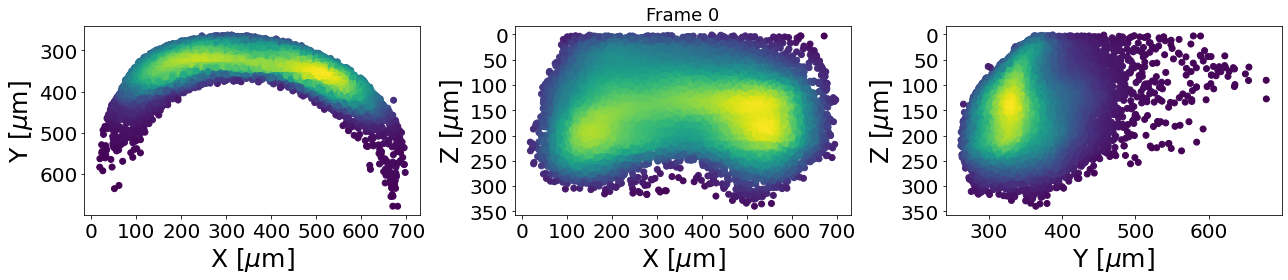

In [19]:
plt.figure(figsize=[18,4])

frame = 0

plt.subplot(131)
# Calculate the point density
xy = np.vstack([spots_xpos_per_frame[frame],spots_ypos_per_frame[frame]])
z = gaussian_kde(xy)(xy)
plt.scatter(spots_xpos_per_frame[frame], spots_ypos_per_frame[frame], c=z)
plt.xlabel('X [$\mu$m]', fontsize=25)
plt.ylabel('Y [$\mu$m]', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.gca().invert_yaxis()

plt.subplot(132)
xy = np.vstack([spots_xpos_per_frame[frame],spots_zpos_per_frame[frame]])
z = gaussian_kde(xy)(xy)
plt.scatter(spots_xpos_per_frame[frame], spots_zpos_per_frame[frame], c=z)
plt.xlabel('X [$\mu$m]', fontsize=25)
plt.ylabel('Z [$\mu$m]', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.gca().invert_yaxis()
plt.title('Frame %d'%frame, fontsize=18)

plt.subplot(133)
xy = np.vstack([spots_ypos_per_frame[frame],spots_zpos_per_frame[frame]])
z = gaussian_kde(xy)(xy)
plt.scatter(spots_ypos_per_frame[frame], spots_zpos_per_frame[frame], c=z)
plt.xlabel('Y [$\mu$m]', fontsize=25)
plt.ylabel('Z [$\mu$m]', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

### LOI segments upload

For this example we use the XY plane only, but depending on the LOI you can also change the planes to YZ or XZ. 

In [23]:
subsampling = 1 # The LOI was segmented from a subsampled image from the .hdf5 file
                # for this reason we need to multiply everything by 2 to upsamble it back. 
    
# Read data from file 'file_path/file_name.txt' 
data_txt_XY = pd.read_csv('%s'%(path_loi),sep='\t')

In [25]:
# XY Plane:
x_ref_xy = np.array(data_txt_XY['X']);

y_ref_xy = np.array(data_txt_XY['Y']);

'''
# XZ Plane:
x_ref_xz = np.zeros((2,len(np.array(data_txt_XZ['X']))))
x_ref_xz[0,:] = np.array(data_txt_XZ['X'])
x_ref_xz[1,:] = np.array(data_txt_XZ['Frame'])

z_ref_xz = np.zeros((2,len(np.array(data_txt_XZ['Y']))))
z_ref_xz[0,:] = np.array(data_txt_XZ['Y'])
z_ref_xz[1,:] = np.array(data_txt_XZ['Frame'])

# YZ Plane:
y_ref_yz = np.zeros((2,len(np.array(data_txt_YZ['X']))))
y_ref_yz[0,:] = np.array(data_txt_YZ['X'])
y_ref_yz[1,:] = np.array(data_txt_YZ['Frame'])

z_ref_yz = np.zeros((2,len(np.array(data_txt_YZ['Y']))))
z_ref_yz[0,:] = np.array(data_txt_YZ['Y'])
z_ref_yz[1,:] = np.array(data_txt_YZ['Frame'])
''';


### Use the first frame as spatial reference

Pin everything to one point of the first frame notochord.

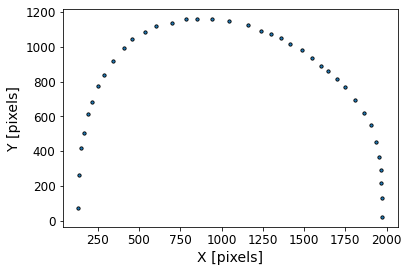

In [26]:
### Keep all the notochords starting at the same position


y_sub_xy = subsampling*((height/subsampling)-y_ref_xy)
x_sub_xy = subsampling*x_ref_xy

R = [x_sub_xy[0], y_sub_xy[0]]
plt.scatter(x_sub_xy, y_sub_xy, s=10, c='black')
plt.gca().invert_yaxis()


y_sub_xy = subsampling*((2048/subsampling)-y_ref_xy)
x_sub_xy = subsampling*x_ref_xy
plt.scatter(np.abs(x_sub_xy-np.abs(x_sub_xy[0]-R[0])), np.abs(y_sub_xy+np.abs(y_sub_xy[0]-R[1])), s=2)
plt.xlabel('X [pixels]', fontsize=14)
plt.ylabel('Y [pixels]', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().invert_yaxis()
plt.show()

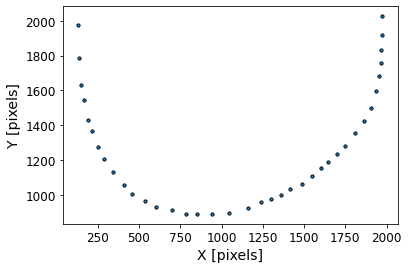

In [27]:
### Keep all the notochords starting at the same position


y_sub_xy = subsampling*y_ref_xy
x_sub_xy = subsampling*x_ref_xy

R = [x_sub_xy[0], y_sub_xy[0]]
plt.scatter(x_sub_xy, y_sub_xy, s=10, c='black')
plt.gca().invert_yaxis()


y_sub_xy = subsampling*y_ref_xy
x_sub_xy = subsampling*x_ref_xy
plt.scatter(np.abs(x_sub_xy-np.abs(x_sub_xy[0]-R[0])), np.abs(y_sub_xy+np.abs(y_sub_xy[0]-R[1])), s=2)
plt.xlabel('X [pixels]', fontsize=14)
plt.ylabel('Y [pixels]', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().invert_yaxis()
plt.show()

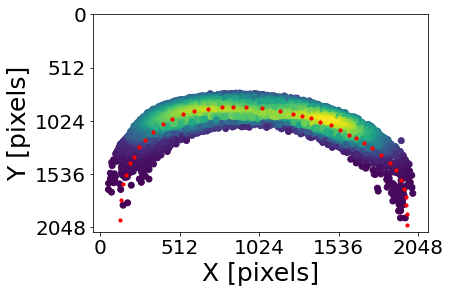

In [28]:
y_sub_xy = subsampling*y_ref_xy
x_sub_xy = subsampling*x_ref_xy

'''
ind = np.where(y_ref_yz[1,:]==frame)[0]
y_sub_yz = subsampling*(y_ref_yz[0,ind])
z_sub_yz = 150-z_ref_yz[0,ind]

ind = np.where(x_ref_xz[1,:]==frame)[0]
x_sub_xz = subsampling*(x_ref_xz[0,ind])
z_sub_xz = 150-z_ref_xz[0,ind]
'''
# Calculate the point densitys
plt.figure(figsize=[6,4])

frame = 0
#plt.subplot(131)
xy = np.vstack([spots_xpos_per_frame[frame],spots_ypos_per_frame[frame]])
z = gaussian_kde(xy)(xy)
plt.scatter(np.array(np.abs(spots_xpos_per_frame[frame]-np.abs(x_sub_xy[0]-R[0])*x_pixel)/x_pixel), \
            np.array(np.abs(spots_ypos_per_frame[frame]+np.abs(y_sub_xy[0]-R[1])*y_pixel)/y_pixel), c=z)
plt.scatter(np.abs(x_sub_xy-np.abs(x_sub_xy[0]-R[0])), np.abs(y_sub_xy+np.abs(y_sub_xy[0]-R[1])), s=10, c='red')
plt.xlabel('X [pixels]', fontsize=25)
plt.ylabel('Y [pixels]', fontsize=25)
plt.xticks(np.arange(0,2048+256,256*2), fontsize=20)
plt.yticks(np.arange(0,2048+256,256*2),fontsize=20)

plt.gca().invert_yaxis()
'''
plt.subplot(132)
xy = np.vstack([spots_ypos_per_frame[frame],spots_zpos_per_frame[frame]])
z = gaussian_kde(xy)(xy)
plt.scatter(np.array(spots_ypos_per_frame[frame])/y_pixel, np.array(spots_zpos_per_frame[frame])/z_pixel, c=z, edgecolor='', alpha=1)
plt.scatter(y_sub_yz, z_sub_yz, s=10, c='red')
plt.xlabel('Y $\mu$m', fontsize=14)
plt.ylabel('Z $\mu$m', fontsize=14)
plt.gca().invert_yaxis()

plt.subplot(133)
xy = np.vstack([spots_xpos_per_frame[frame],spots_zpos_per_frame[frame]])
z = gaussian_kde(xy)(xy)
plt.scatter(np.array(spots_xpos_per_frame[frame])/x_pixel, np.array(spots_zpos_per_frame[frame])/z_pixel, c=z, edgecolor='', alpha=1)
plt.scatter(x_sub_xz, z_sub_xz, s=10, c='red')
plt.xlabel('X $\mu$m', fontsize=14)
plt.ylabel('z $\mu$m', fontsize=14)
plt.gca().invert_yaxis()

plt.tight_layout()
'''
plt.show()

You can change the value of "frame" to check if the Notochord is in the center of the tail's embryo in different frames. 

### Remove some tracks according to their position

In this case, we use the Notochord as our reference and we expand an area of 200 pixels in each side of the notochord (which multiplied by the pixel value we obtain the size in $\mu$m. 
All spots which fall outside this area are discarted, so we significantly reduce the number of tracks. 

In [29]:
# XY Track criteria removal
width = 500 # 300 pixels each side 
n_spots_total = n_spots

print('The PSM is %d um wide'%(width*x_pixel))
count = 0

spots_xdist_per_frame = {key:[] for key in np.arange(n_frames)}
spots_ydist_per_frame = {key:[] for key in np.arange(n_frames)}

# To calculate the minimum and maximum distances --> To be able to normalize the spatial reference from 0-1
min_dist = np.inf
max_dist = 0


for i in range(n_frames):
    # Indices of which spots to remove
    ind = []
    aux_xdist = []
    aux_ydist = []
       
    # Positions from the notochord segmentation
    y0 = subsampling*y_ref_xy
    x0 = subsampling*x_ref_xy
    
    # Positions from the Tracks + Remove the offset to align all of them with respect the Notochord at t=0
    x = np.array(np.abs(spots_xpos_per_frame[i]-np.abs(x0[0]-R[0])*x_pixel)/x_pixel)
    y = np.array(np.abs(spots_ypos_per_frame[i]+np.abs(y0[0]-R[1])*y_pixel)/y_pixel)
        
    # Remove offset to allign them all with respect first point of notochord at t=0
    x0 = np.abs(x0-np.abs(x0[0]-R[0]))
    y0 = np.abs(y0+np.abs(y0[0]-R[1]))
    
    for j in range(len(x)): # For the amount of spots in each frame
        # Eucledian distance
        dist = np.sqrt( (x[j]-x0)**2 + (y[j]-y0)**2 )
        
        if min(dist) > width/2:
            ind.append(j)
        else:
            aux_xdist.append(list(map(int,x0[(np.where(dist == min(dist))[0])])))
            aux_ydist.append(list(map(int,y0[(np.where(dist == min(dist))[0])])))
            # To obtain min x-y and max x-y
                
    # If the distance is higher than the width of the PSM
    # then we do not take this track into account
    for j in range(len(ind)):
 
        spots_ch0_per_frame[i].remove(spots_ch0_per_frame[i][ind[j]-j])
        spots_ch1_per_frame[i].remove(spots_ch1_per_frame[i][ind[j]-j])
        spots_xpos_per_frame[i].remove(spots_xpos_per_frame[i][ind[j]-j])
        spots_ypos_per_frame[i].remove(spots_ypos_per_frame[i][ind[j]-j])
        spots_zpos_per_frame[i].remove(spots_zpos_per_frame[i][ind[j]-j])
        count += 1
    
    spots_xdist_per_frame[i].append([item for sublist in aux_xdist for item in sublist])
    spots_ydist_per_frame[i].append([item for sublist in aux_ydist for item in sublist])
        
    if len(x0) < min_dist:
        min_dist = len(x0)
    if len(x0) > max_dist:
        max_dist = len(x0)
        

The PSM is 173 um wide


In [ ]:
# Sanity check
print('Initial Number of spots was: %d, The final number of spots is: %d'%(n_spots, (n_spots)-count))

In [ ]:
frame = 0

y_sub_xy = subsampling*y_ref_xy
x_sub_xy = subsampling*x_ref_xy
'''
ind = np.where(y_ref_yz[1,:]==frame)[0]
y_sub_yz = subsampling*(y_ref_yz[0,ind])
z_sub_yz = 150-z_ref_yz[0,ind]

ind = np.where(x_ref_xz[1,:]==frame)[0]
x_sub_xz = subsampling*(x_ref_xz[0,ind])
z_sub_xz = 150-z_ref_xz[0,ind]
'''
# Calculate the point densitys
plt.figure(figsize=[12,4])

plt.subplot(131)
xy = np.vstack([spots_xpos_per_frame[frame],spots_ypos_per_frame[frame]])
z = gaussian_kde(xy)(xy)
plt.scatter(np.array(np.abs(spots_xpos_per_frame[frame]-np.abs(x_sub_xy[0]-R[0])*x_pixel)/x_pixel), \
            np.array(np.abs(spots_ypos_per_frame[frame]+np.abs(y_sub_xy[0]-R[1])*y_pixel)/y_pixel), c=z, edgecolor='', alpha=1)
plt.scatter(np.abs(x_sub_xy-np.abs(x_sub_xy[0]-R[0])), np.abs(y_sub_xy+np.abs(y_sub_xy[0]-R[1])), s=10, c='red')
plt.xlabel('X $\mu$m', fontsize=14)
plt.ylabel('Y $\mu$m', fontsize=14)

plt.gca().invert_yaxis()

plt.subplot(132)
xy = np.vstack([spots_ypos_per_frame[frame],spots_zpos_per_frame[frame]])
z = gaussian_kde(xy)(xy)
plt.scatter(np.array(spots_ypos_per_frame[frame])/y_pixel, np.array(spots_zpos_per_frame[frame])/z_pixel, c=z, edgecolor='', alpha=1)
#plt.scatter(y_sub_yz, z_sub_yz, s=10, c='red')
plt.xlabel('Y $\mu$m', fontsize=14)
plt.ylabel('Z $\mu$m', fontsize=14)
plt.gca().invert_yaxis()

plt.subplot(133)
xy = np.vstack([spots_xpos_per_frame[frame],spots_zpos_per_frame[frame]])
z = gaussian_kde(xy)(xy)
plt.scatter(np.array(spots_xpos_per_frame[frame])/x_pixel, np.array(spots_zpos_per_frame[frame])/z_pixel, c=z, edgecolor='', alpha=1)
#plt.scatter(x_sub_xz, z_sub_xz, s=10, c='red')
plt.xlabel('X $\mu$m', fontsize=14)
plt.ylabel('z $\mu$m', fontsize=14)
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

## LabKit Data

In [74]:
#labkit_data = '20201120_151157_98/Position1-labellingBitmap.tif'
label = 'PSM'
labeling = 'D:/Arianne/20191213_134254_29/Position1_20191213_SOM_LR.txt'

In [67]:
labeling_file = open(labeling, "r")
for line in labeling_file:
    pass

labeling_dict = eval(line)

In [79]:
labels = labeling_dict['labels'][label]
x_aux = []
y_aux = []
z_aux = []

for i in range(len(labels)):
    x_aux.append(labels[i][0])
    y_aux.append(labels[i][1])
    z_aux.append(labels[i][2])
    
x = np.array(x_aux)
y = np.array(y_aux)
z = np.array(z_aux)

In [80]:
bitmap = np.zeros((width, height, n_slices))
bitmap[x,y,z] = 1

Text(0, 0.5, 'Y [pixels]')

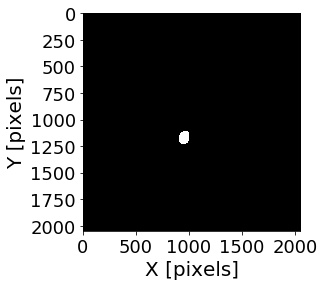

In [84]:
plt.imshow(bitmap[:,:,50], cmap='Greys_r')
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.xlabel('X [pixels]', fontsize=20)
plt.ylabel('Y [pixels]', fontsize=20)

In [86]:
frame = 0

spots_to_remove = []
spots_to_keep = []

for i in range(n_spots):
    # Convert the spots position into pixels (fromt micrometers)
    x = int(np.round(spots_xpos_per_frame[frame][i]/x_pixel))
    y = int(np.round(spots_ypos_per_frame[frame][i]/y_pixel))
    z = int(np.round(spots_zpos_per_frame[frame][i]/z_pixel))
    
    # Check if that position is inside the PSM labeled data
    if bitmap[x,y,z]==0:
        spots_to_remove.append(i)
    else:
        spots_to_keep.append(i)
        

### Spots to keep plot

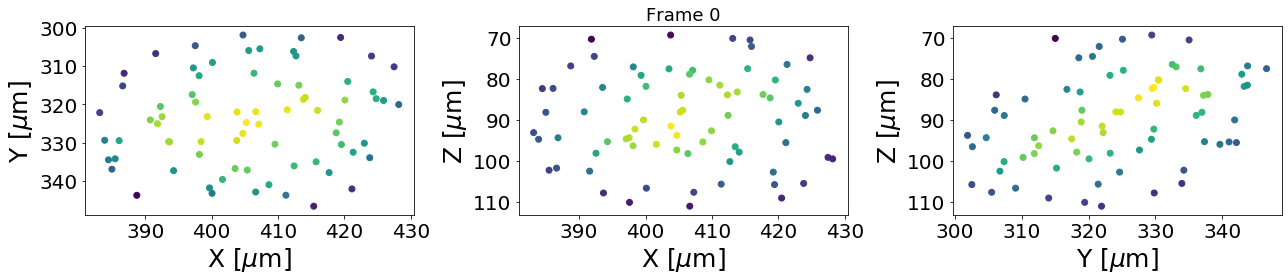

In [87]:
plt.figure(figsize=[18,4])

frame = 0

plt.subplot(131)
# Calculate the point density
xy = np.vstack([np.array(spots_xpos_per_frame[frame])[np.array(spots_to_keep)],np.array(spots_ypos_per_frame[frame])[np.array(spots_to_keep)]])
z = gaussian_kde(xy)(xy)
plt.scatter(np.array(spots_xpos_per_frame[frame])[np.array(spots_to_keep)], np.array(spots_ypos_per_frame[frame])[np.array(spots_to_keep)], c=z)
plt.xlabel('X [$\mu$m]', fontsize=25)
plt.ylabel('Y [$\mu$m]', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.gca().invert_yaxis()

plt.subplot(132)
xy = np.vstack([np.array(spots_xpos_per_frame[frame])[np.array(spots_to_keep)],np.array(spots_zpos_per_frame[frame])[np.array(spots_to_keep)]])
z = gaussian_kde(xy)(xy)
plt.scatter(np.array(spots_xpos_per_frame[frame])[np.array(spots_to_keep)], np.array(spots_zpos_per_frame[frame])[np.array(spots_to_keep)], c=z)
plt.xlabel('X [$\mu$m]', fontsize=25)
plt.ylabel('Z [$\mu$m]', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.gca().invert_yaxis()
plt.title('Frame %d'%frame, fontsize=18)

plt.subplot(133)
xy = np.vstack([np.array(spots_ypos_per_frame[frame])[np.array(spots_to_keep)], np.array(spots_zpos_per_frame[frame])[np.array(spots_to_keep)]])
z = gaussian_kde(xy)(xy)
plt.scatter(np.array(spots_ypos_per_frame[frame])[np.array(spots_to_keep)], np.array(spots_zpos_per_frame[frame])[np.array(spots_to_keep)], c=z)
plt.xlabel('Y [$\mu$m]', fontsize=25)
plt.ylabel('Z [$\mu$m]', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

In [88]:
y_sub_xy = subsampling*y_ref_xy
x_sub_xy = subsampling*x_ref_xy

# Calculate the point densitys
plt.figure(figsize=[8,6])

frame = 0
#plt.subplot(131)
xy = np.vstack([spots_xpos_per_frame[frame],spots_ypos_per_frame[frame]])
z = gaussian_kde(xy)(xy)
plt.scatter(np.array(np.abs(spots_xpos_per_frame[frame]-np.abs(x_sub_xy[0]-R[0])*x_pixel)/x_pixel), \
            np.array(np.abs(spots_ypos_per_frame[frame]+np.abs(y_sub_xy[0]-R[1])*y_pixel)/y_pixel), c='black', alpha=0.2)#c=z, cmap='')
plt.scatter(np.abs(x_sub_xy-np.abs(x_sub_xy[0]-R[0])), np.abs(y_sub_xy+np.abs(y_sub_xy[0]-R[1])), s=10, c='red')
plt.xlabel('X [pixels]', fontsize=20)
plt.ylabel('Y [pixels]', fontsize=20)
plt.xticks(np.arange(0,2048+256,256), fontsize=18)
plt.yticks(np.arange(0,2048+256,256),fontsize=18)


xy = np.vstack([np.array(spots_xpos_per_frame[frame])[np.array(spots_to_keep)],np.array(spots_ypos_per_frame[frame])[np.array(spots_to_keep)]])
z = gaussian_kde(xy)(xy)
plt.scatter(np.array(np.abs(np.array(spots_xpos_per_frame[frame])[np.array(spots_to_keep)]-np.abs(x_sub_xy[0]-R[0])*x_pixel)/x_pixel), \
            np.array(np.abs(np.array(spots_ypos_per_frame[frame])[np.array(spots_to_keep)]+np.abs(y_sub_xy[0]-R[1])*y_pixel)/y_pixel), c=z, cmap='viridis')
plt.scatter(np.abs(x_sub_xy-np.abs(x_sub_xy[0]-R[0])), np.abs(y_sub_xy+np.abs(y_sub_xy[0]-R[1])), s=10, c='red')
plt.xlabel('X [pixels]', fontsize=20)
plt.ylabel('Y [pixels]', fontsize=20)
plt.xticks(np.arange(0,2048+256,256), fontsize=18)
plt.yticks(np.arange(0,2048+256,256),fontsize=18)

plt.gca().invert_yaxis()

plt.show()

NameError: name 'subsampling' is not defined

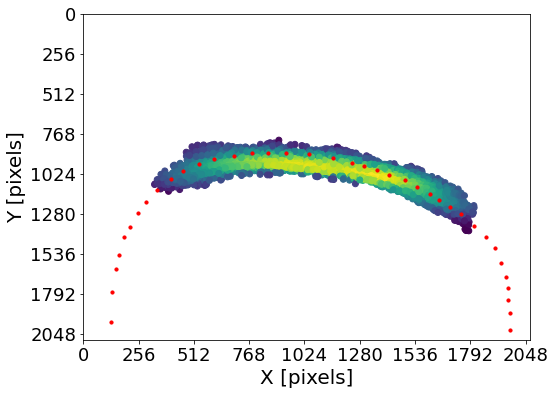

In [18]:
y_sub_xy = subsampling*y_ref_xy
x_sub_xy = subsampling*x_ref_xy

# Calculate the point densitys
plt.figure(figsize=[8,6])

frame = 0
#plt.subplot(131)


xy = np.vstack([np.array(spots_xpos_per_frame[frame])[np.array(spots_to_keep)],np.array(spots_ypos_per_frame[frame])[np.array(spots_to_keep)]])
z = gaussian_kde(xy)(xy)
plt.scatter(np.array(np.abs(np.array(spots_xpos_per_frame[frame])[np.array(spots_to_keep)]-np.abs(x_sub_xy[0]-R[0])*x_pixel)/x_pixel), \
            np.array(np.abs(np.array(spots_ypos_per_frame[frame])[np.array(spots_to_keep)]+np.abs(y_sub_xy[0]-R[1])*y_pixel)/y_pixel), c=z, cmap='viridis')
plt.scatter(np.abs(x_sub_xy-np.abs(x_sub_xy[0]-R[0])), np.abs(y_sub_xy+np.abs(y_sub_xy[0]-R[1])), s=10, c='red')
plt.xlabel('X [pixels]', fontsize=20)
plt.ylabel('Y [pixels]', fontsize=20)
plt.xticks(np.arange(0,2048+256,256), fontsize=18)
plt.yticks(np.arange(0,2048+256,256),fontsize=18)

plt.gca().invert_yaxis()

plt.show()

## Remove Spots which are not in the PSM

In [90]:
# Open the  XML file of your original data to write and edit
# Then we will save and edit a new xml file

path_xml = 'D:/Arianne/20191213_134254_29/Position1_20191213_SOM_BT_ABR_mamut.xml'
tree = ElementTree()
tree.parse(path_xml)

<Element 'TrackMate' at 0x0000029BC18B2F98>

In [91]:
# XML Declaration

f = BytesIO()
tree.write(f, encoding='utf-8', xml_declaration=True) 

In [92]:
# Correct the units
units = 'micron'
for TrackMate in tree.iter('TrackMate'):
    for Model in TrackMate.iter('Model'):
        # Change value
        Model.set('spatialunits', '%s'%units)

### Edit the xml file

In [93]:
n_spots_left = len(spots_to_keep)

# First thing to change is "nspots":
for Model in tree.iter('Model'):
    for AllSpots in Model.iter('AllSpots'):
        # Change value
        AllSpots.set('nspots', '%d'%n_spots_left)

In [94]:
import time

In [95]:
t = time.time()    

spots_ID_to_remove = np.array(spots_ID_per_frame[frame])[np.array(spots_to_remove)]

# Delete the Spots that are no longer in the tracks of interest
for SpotsInFrame in tree.iter('SpotsInFrame'):
    for Spot in SpotsInFrame.findall('Spot'):
        if len(np.where(int(Spot.attrib['ID'])==spots_ID_to_remove)[0])>0:
            SpotsInFrame.remove(Spot)

print(time.time() - t)

0.10999798774719238


In [96]:
# Write a new xml with only the kept spots
tree.write('D:/Arianne/20191213_134254_29/output_Position1-mamut.xml')
elapsed = time.time() - t
print('Time in seconds: %d'%elapsed)

Time in seconds: 19


### Check curated data

Once the new xml has been manually curated in Mastodon, we can plot the resulting data.

In [193]:
path_xml = '20201120_151157_98/Position1-cropped_mamut.xml'
path_real_xml = '20201120_151157_98/Position1.xml'

n_frames = 1
obj = untangle.parse(path_xml)

# Parse .xml file
obj1 = untangle.parse(path_real_xml)

# Data Features
width = int(obj1.SpimData.SequenceDescription.ViewSetups.ViewSetup[0].size.cdata.split()[0])
height = int(obj1.SpimData.SequenceDescription.ViewSetups.ViewSetup[0].size.cdata.split()[1])
n_slices = int(obj1.SpimData.SequenceDescription.ViewSetups.ViewSetup[0].size.cdata.split()[2])

x_pixel = float(obj1.SpimData.SequenceDescription.ViewSetups.ViewSetup[0].voxelSize.size.cdata.split()[0])
y_pixel = float(obj1.SpimData.SequenceDescription.ViewSetups.ViewSetup[0].voxelSize.size.cdata.split()[1])
z_pixel = float(obj1.SpimData.SequenceDescription.ViewSetups.ViewSetup[0].voxelSize.size.cdata.split()[2])

channels = len(obj1.SpimData.SequenceDescription.ViewSetups.ViewSetup)
while True:
    try:
        n_frames = len(obj1.SpimData.SequenceDescription.Timepoints.integerpattern.cdata.split())
        break
    except AttributeError:
        pass  # fallback to dict
    try:
        n_frames = int(obj1.SpimData.SequenceDescription.Timepoints.last.cdata.split()[0])+1
        break
    except KeyError:
        raise AttributeError("There is something wrong with the .xml file") from None
        

units = obj1.SpimData.SequenceDescription.ViewSetups.ViewSetup[0].voxelSize.unit.cdata

print('The image has the following dimensions (XYZC): %d, %d, %d, %d'%(width, height, n_slices, channels))
print('There are %d frames in total.'%n_frames)
print('Pixel Size: x = %.3g %s, y = %.3g %s z = %.2g %s'%(x_pixel, units, y_pixel, units, z_pixel, units))
print('There are %d Z-slices in total'%n_slices)

The image has the following dimensions (XYZC): 2048, 2048, 230, 3
There are 1 frames in total.
Pixel Size: x = 0.347 micron, y = 0.347 micron z = 1.5 micron
There are 230 Z-slices in total


In [194]:
n_spots = int(obj.TrackMate.Model.AllSpots['nspots'])
print('There are %d number of cells in total in Looping.'%n_spots)

There are 2492 number of cells in total in Looping.


### Ordering the tracks ID
Create a list called *spots_track_ID* which has the following structure:

[ track number 1: { spot ID 1, spot ID 2, ... } ] ; [ track number 2: { spot ID 1, spot ID 2, ... } ] ; ...

Each track represents the entire track of a single cell and each spot corresponds to the cell in a given frame. 

In [195]:
# Create array with the ID of each track
spots_ch0_per_frame =  {key:[] for key in np.arange(n_frames)}
spots_ch1_per_frame =  {key:[] for key in np.arange(n_frames)}
spots_xpos_per_frame =  {key:[] for key in np.arange(n_frames)}
spots_ypos_per_frame =  {key:[] for key in np.arange(n_frames)}
spots_zpos_per_frame =  {key:[] for key in np.arange(n_frames)}
spots_ID_per_frame =  {key:[] for key in np.arange(n_frames)}


i = 0

n_spots_in_frame = len(obj.TrackMate.Model.AllSpots.SpotsInFrame) # For Looping
for j in range(n_spots_in_frame):
    spots_ch0_per_frame[i].append(float(obj.TrackMate.Model.AllSpots.SpotsInFrame.Spot[j]['Spot_gaussian-filtered_intensity_Mean_ch0']))
    spots_ch1_per_frame[i].append(float(obj.TrackMate.Model.AllSpots.SpotsInFrame.Spot[j]['Spot_gaussian-filtered_intensity_Mean_ch1']))
    spots_xpos_per_frame[i].append(float(obj.TrackMate.Model.AllSpots.SpotsInFrame.Spot[j]['POSITION_X']))
    spots_ypos_per_frame[i].append(float(obj.TrackMate.Model.AllSpots.SpotsInFrame.Spot[j]['POSITION_Y']))
    spots_zpos_per_frame[i].append(float(obj.TrackMate.Model.AllSpots.SpotsInFrame.Spot[j]['POSITION_Z']))
    spots_ID_per_frame[i].append(int(obj.TrackMate.Model.AllSpots.SpotsInFrame.Spot[j]['ID']))

### Plot the results

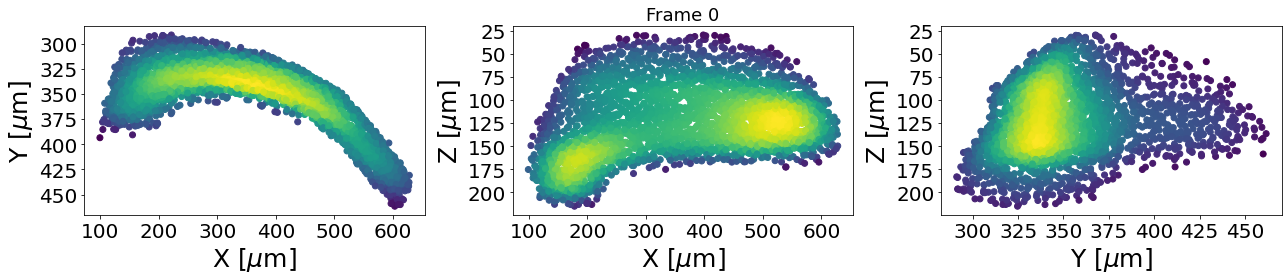

In [196]:
plt.figure(figsize=[18,4])

frame = 0

plt.subplot(131)
# Calculate the point density
xy = np.vstack([spots_xpos_per_frame[frame],spots_ypos_per_frame[frame]])
z = gaussian_kde(xy)(xy)
plt.scatter(spots_xpos_per_frame[frame], spots_ypos_per_frame[frame], c=z)
plt.xlabel('X [$\mu$m]', fontsize=25)
plt.ylabel('Y [$\mu$m]', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.gca().invert_yaxis()

plt.subplot(132)
xy = np.vstack([spots_xpos_per_frame[frame],spots_zpos_per_frame[frame]])
z = gaussian_kde(xy)(xy)
plt.scatter(spots_xpos_per_frame[frame], spots_zpos_per_frame[frame], c=z)
plt.xlabel('X [$\mu$m]', fontsize=25)
plt.ylabel('Z [$\mu$m]', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.gca().invert_yaxis()
plt.title('Frame %d'%frame, fontsize=18)

plt.subplot(133)
xy = np.vstack([spots_ypos_per_frame[frame],spots_zpos_per_frame[frame]])
z = gaussian_kde(xy)(xy)
plt.scatter(spots_ypos_per_frame[frame], spots_zpos_per_frame[frame], c=z)
plt.xlabel('Y [$\mu$m]', fontsize=25)
plt.ylabel('Z [$\mu$m]', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

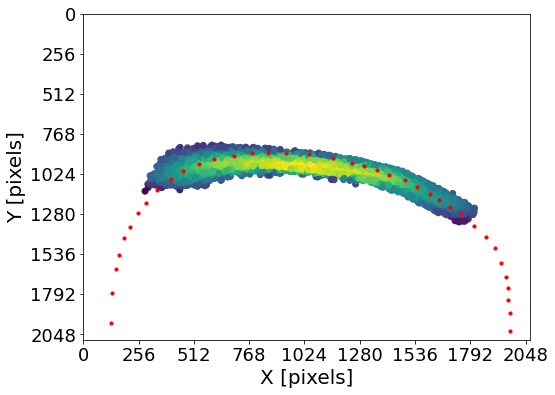

In [197]:
y_sub_xy = subsampling*y_ref_xy
x_sub_xy = subsampling*x_ref_xy

'''
ind = np.where(y_ref_yz[1,:]==frame)[0]
y_sub_yz = subsampling*(y_ref_yz[0,ind])
z_sub_yz = 150-z_ref_yz[0,ind]

ind = np.where(x_ref_xz[1,:]==frame)[0]
x_sub_xz = subsampling*(x_ref_xz[0,ind])
z_sub_xz = 150-z_ref_xz[0,ind]
'''
# Calculate the point densitys
plt.figure(figsize=[8,6])

frame = 0
#plt.subplot(131)
xy = np.vstack([spots_xpos_per_frame[frame],spots_ypos_per_frame[frame]])
z = gaussian_kde(xy)(xy)
plt.scatter(np.array(np.abs(spots_xpos_per_frame[frame]-np.abs(x_sub_xy[0]-R[0])*x_pixel)/x_pixel), \
            np.array(np.abs(spots_ypos_per_frame[frame]+np.abs(y_sub_xy[0]-R[1])*y_pixel)/y_pixel), c=z)
plt.scatter(np.abs(x_sub_xy-np.abs(x_sub_xy[0]-R[0])), np.abs(y_sub_xy+np.abs(y_sub_xy[0]-R[1])), s=10, c='red')
plt.xlabel('X [pixels]', fontsize=20)
plt.ylabel('Y [pixels]', fontsize=20)
plt.xticks(np.arange(0,2048+256,256), fontsize=18)
plt.yticks(np.arange(0,2048+256,256),fontsize=18)

plt.gca().invert_yaxis()
'''
plt.subplot(132)
xy = np.vstack([spots_ypos_per_frame[frame],spots_zpos_per_frame[frame]])
z = gaussian_kde(xy)(xy)
plt.scatter(np.array(spots_ypos_per_frame[frame])/y_pixel, np.array(spots_zpos_per_frame[frame])/z_pixel, c=z, edgecolor='', alpha=1)
plt.scatter(y_sub_yz, z_sub_yz, s=10, c='red')
plt.xlabel('Y $\mu$m', fontsize=14)
plt.ylabel('Z $\mu$m', fontsize=14)
plt.gca().invert_yaxis()

plt.subplot(133)
xy = np.vstack([spots_xpos_per_frame[frame],spots_zpos_per_frame[frame]])
z = gaussian_kde(xy)(xy)
plt.scatter(np.array(spots_xpos_per_frame[frame])/x_pixel, np.array(spots_zpos_per_frame[frame])/z_pixel, c=z, edgecolor='', alpha=1)
plt.scatter(x_sub_xz, z_sub_xz, s=10, c='red')
plt.xlabel('X $\mu$m', fontsize=14)
plt.ylabel('z $\mu$m', fontsize=14)
plt.gca().invert_yaxis()

plt.tight_layout()
'''
plt.show()

# Create a Graph - GRAPH FOURIER TRANSFORM ANALYSIS

### Arrange the data

In [198]:
# In micrometers!
x_p = np.array(spots_xpos_per_frame[frame])
y_p = np.array(spots_ypos_per_frame[frame])
z_p = np.array(spots_zpos_per_frame[frame])

intensity = np.array(spots_ch0_per_frame[frame])

xyz_matrix = np.array([x_p, y_p, z_p]).T

### Adjacency Matrix of the Graph

Text(0, 0.5, 'Cells')

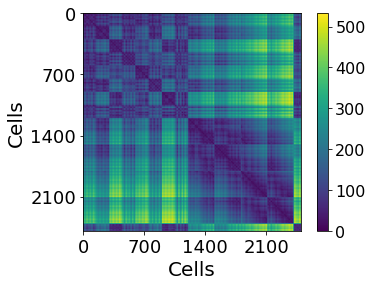

In [199]:
dist_matrix = squareform(pdist(xyz_matrix))

ax = plt.imshow(dist_matrix, cmap='viridis')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.xticks(np.arange(0,2500,700), fontsize=18)
plt.yticks(np.arange(0,2500,700), fontsize=18)
plt.xlabel('Cells', fontsize=20)
plt.ylabel('Cells', fontsize=20)

Now we want to keep the local edges, e.g. the cells which are neighbors. 

### $\epsilon$ - ball Method

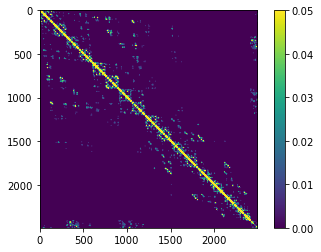

In [200]:
# Radius in micrometers
epsilon = 12

mask = dist_matrix<=epsilon

# Make diagonal equal to 0
mask[np.diag_indices(len(mask))] = 0

plt.imshow(mask, vmax=0.05)
plt.colorbar()

To choose $\epsilon$ we can check with how many cells each one of them is connected. For that we do:

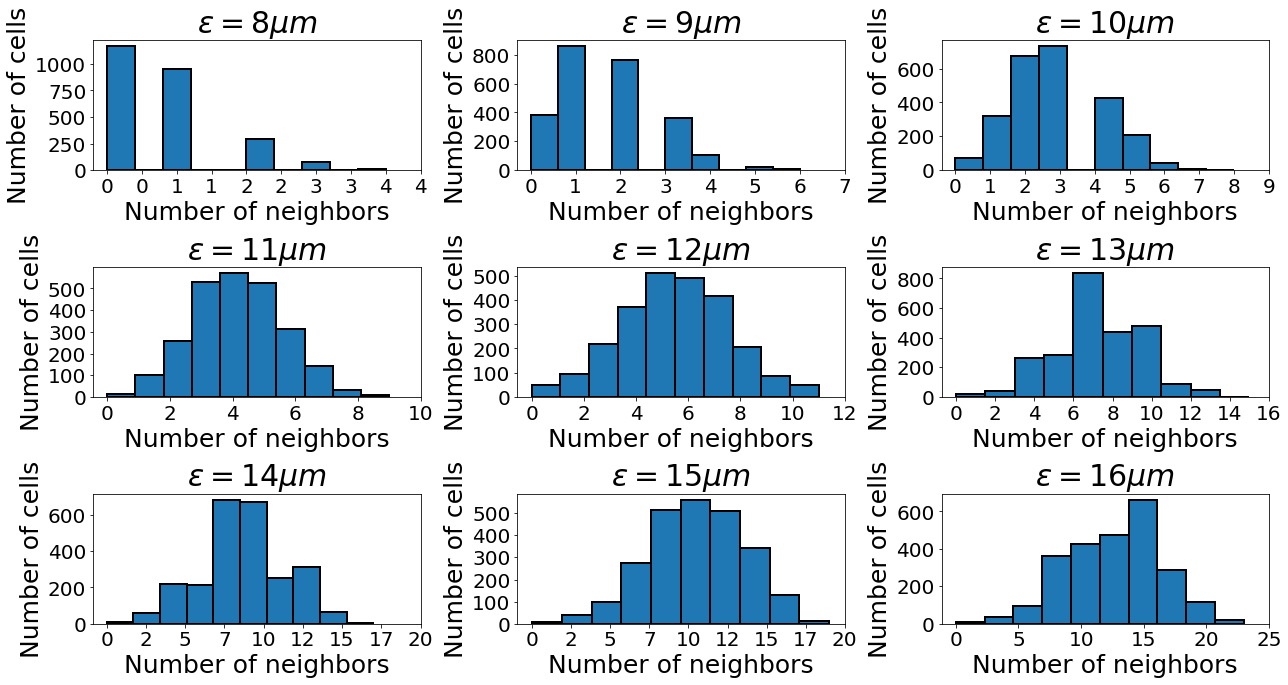

In [201]:
# Check Neighbors distribution with different radius sizes
dim = 0

eps = [8,9,10,11,12,13,14,15,16]


n_cols =  3
n_rows = np.ceil((len(eps) + 1) / n_cols)
plot_num = 1


ax = plt.figure(figsize=[18,12])
aux = []

for j in range(len(eps)):
    
    # Update the number of subplots    
    ax = plt.subplot(int(n_rows), n_cols, plot_num, aspect='auto')
    plot_num += 1
    
    mask = dist_matrix<=eps[j]

    # Make diagonal equal to 0
    mask[np.diag_indices(len(mask))] = 0
    
    aux.append(np.sum(mask, dim))
    
    plt.hist(np.sum(mask, dim), edgecolor='black', linewidth=2)
    
    
    locs, labels = plt.xticks()
    plt.xticks(locs[1:], map(int,locs[1:]), fontsize=20);
    plt.yticks(fontsize=20);
    plt.ylabel('Number of cells', fontsize=25)
    plt.xlabel('Number of neighbors', fontsize=25)
    plt.title('$\epsilon= %d \mu m$'%eps[j], fontsize=30)
plt.tight_layout()
plt.show()

In [202]:
bins=np.histogram(np.hstack((aux)), bins=10)[1] #get the bin edges

In [203]:
# Is there any cell not connected? If 0, then yes otherwise no
np.min(np.sum(mask,dim))

0

### Ridge Plot 

To better see the distribution of cells according to their number of neighbours. 

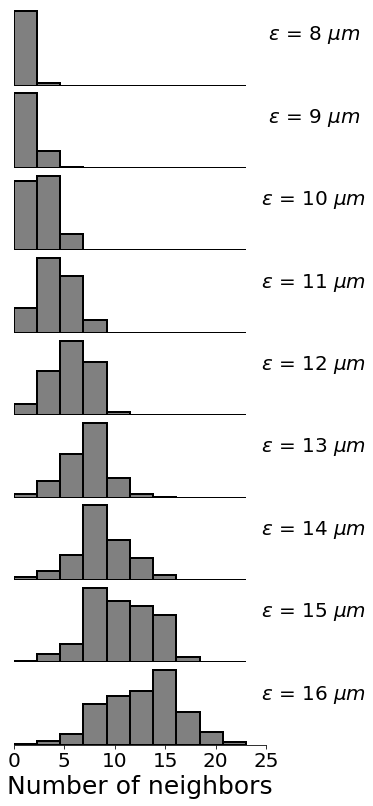

In [204]:
# Check Neighbors distribution with different radius sizes
dim = 0

eps = [8,9,10,11,12,13,14,15,16]


n_cols =  1
n_rows = np.ceil((len(eps) + 1) / n_cols)
plot_num = 1


ax = plt.figure(figsize=[4,10])

for j in range(len(eps)):
    
    # Update the number of subplots    
    ax = plt.subplot(int(n_rows), n_cols, plot_num, aspect='auto')
    plot_num += 1
    
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    if j!= len(eps):
        ax.set_xticklabels([])
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
    if j == len(eps)-1:
        ax.spines['bottom'].set_visible(True)
        
    mask = dist_matrix<=eps[j]

    # Make diagonal equal to 0
    mask[np.diag_indices(len(mask))] = 0

    plt.hist(np.sum(mask, dim), color='grey',edgecolor='black', linewidth=2, bins=bins)
    plt.xlim([0,25])
    
    plt.ylabel('$\epsilon$ = %d $\mu m$'%eps[j], fontsize=20, rotation=0,labelpad=-300)
    
    if j==len(eps)-1:
        locs, labels = plt.xticks()
        plt.xticks(locs, map(int,locs), fontsize=20);
        plt.yticks([]);
        #plt.ylabel('Number of cells', fontsize=25)
        plt.xlabel('Number of neighbors', fontsize=25)
    else:
        plt.xticks([])
        plt.yticks([])
    #plt.title('$\epsilon= %d \mu m$'%eps[j], fontsize=30)
    
    
plt.tight_layout(pad=-5)
plt.show()

## Variability Analysis

$x_{i}$: Intensity of cell $i$. 

$v_{i}$:Variability of cell $i$.

$v_{i}=\sum_{j\in N_{i}} \frac{(x_{i}-y_{j})^{2}}{N_{i}}$

In [205]:
cells_with_no_neighbors = []
cell_variability = []
cell_norm_variability = []

for i in range(n_spots):
    # Find the neighbors of cell i
    neighbors = np.where(mask[i,:]==1)[0]
    
    # Obtain the intensity of cell i 
    x_i = intensity[i]
    
    # If there are neighbors
    if np.size(neighbors)>0:
        aux = 0
        for j in neighbors:
            y_i = intensity[j]
            aux += (x_i-y_i)**2
        
        cell_variability.append(np.sqrt(aux/len(neighbors)))
        cell_norm_variability.append(aux/x_i)
        
       
    # Save the position of the cells which have no neighbors
    else:
        cells_with_no_neighbors.append(i)
        cell_variability.append(np.nan)
        cell_norm_variability.append(np.nan)

## Plot the results

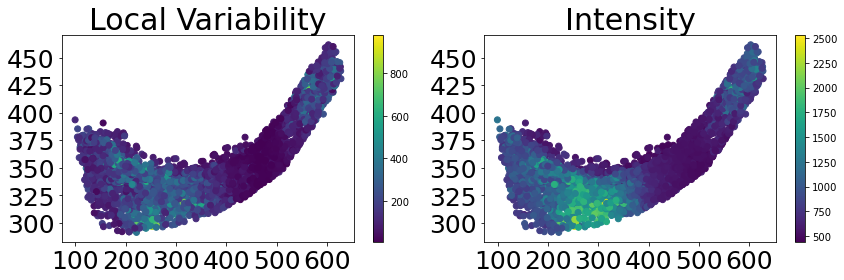

In [206]:
plt.figure(figsize=[12,4])
plt.subplot(121)
plt.scatter(x_p, y_p, c=cell_variability, alpha=1)
plt.colorbar()

plt.title('Local Variability', fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.subplot(122)
plt.scatter(x_p, y_p, c=intensity, alpha=1)
plt.colorbar()

plt.title('Intensity', fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.tight_layout()
plt.show()

## Project to the Notochord

### Equidistant points: to increase spatial resolution

In [207]:
def getEquidistantPoints(p1, p2, parts):
    return zip(np.linspace(p1[0], p2[0], parts+1), np.linspace(p1[1], p2[1], parts+1))

list(getEquidistantPoints((1,1), (5,5), 4))[0]

x_not_equidist = []
y_not_equidist = []
notochord_points = len(x_sub_xy)
n_points = 20 # Number of points to add 
    
# Initial number of points from fiji
x = x_sub_xy
y = y_sub_xy

x_aux = []
y_aux = []

for j in range(notochord_points-1):
    aux = list(getEquidistantPoints((x[j],y[j]),(x[j+1],y[j+1]), n_points))

    # For each of the inserted points
    for k in range(len(aux)-1):
        x_aux.append(aux[k][0])
        y_aux.append(aux[k][1])

x_not_equidist.append(x_aux)
y_not_equidist.append(y_aux)
    
print('Number of timepoints: %d'%np.shape(x_not_equidist)[0])
print('Number of points per timepoint: %d'%np.shape(x_not_equidist)[1])

Number of timepoints: 1
Number of points per timepoint: 740


Text(0, 0.5, 'Y [pixels]')

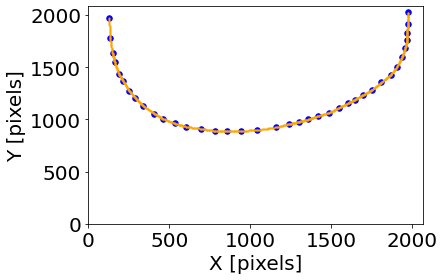

In [208]:
plt.figure(figsize=[6,4])

plt.scatter(x_sub_xy, y_sub_xy, s=30, color='blue')
plt.scatter(x_not_equidist, y_not_equidist, s=1,color='orange')


plt.xticks(np.arange(0,2050, 500), fontsize=20)
plt.yticks(np.arange(0,2050, 500),fontsize=20)
plt.xlabel('X [pixels]', fontsize=20)
plt.ylabel('Y [pixels]', fontsize=20)

In [232]:
mask = dist_matrix<=epsilon

# Make diagonal equal to 0
mask[np.diag_indices(len(mask))] = 0

# Number of neighbors per cell
n_neighbors = []

for i in range(n_spots):
    n_neighbors.append(len(np.where(mask[i,:]==True)[0]))

n_neighbors = np.array(n_neighbors)

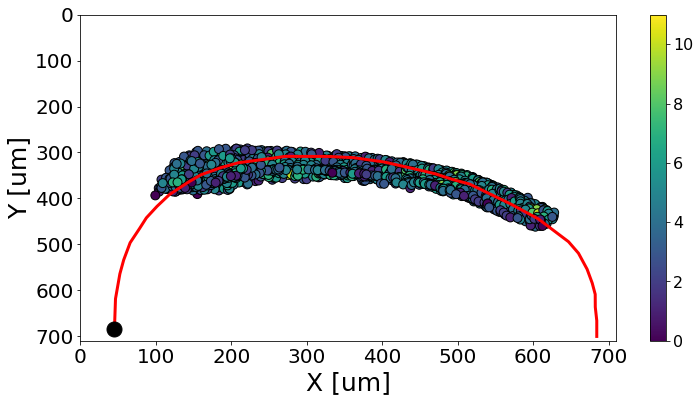

In [241]:
ax = plt.figure(figsize=[12,6])

tp = 0
plt.plot(np.array(x_not_equidist[tp])*x_pixel, (np.array(y_not_equidist[tp]))*y_pixel, linewidth=3, color='red')
plt.plot(x_not_equidist[tp][0]*x_pixel,(y_not_equidist[tp][0])*y_pixel,'o',color='black', markersize=15 )

plt.scatter(spots_xpos_per_frame[tp], spots_ypos_per_frame[tp], c=n_neighbors, edgecolor='black', linewidth=1, s=80, alpha=1)

plt.xlim([0,2048*x_pixel])
plt.ylim([0,2048*y_pixel])

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('X [um]', fontsize=25)
plt.ylabel('Y [um]', fontsize=25)
cbar = plt.colorbar()

cbar.ax.tick_params(labelsize=16)
plt.gca().invert_yaxis()

plt.show()

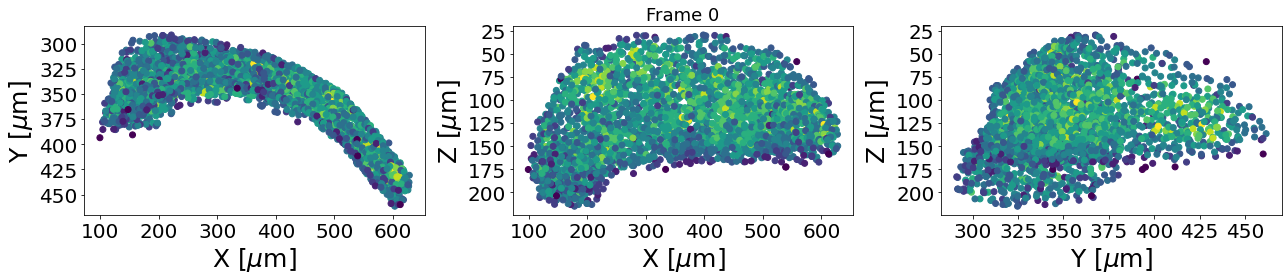

In [235]:
plt.figure(figsize=[18,4])

frame = 0

plt.subplot(131)
# Calculate the point density
xy = np.vstack([spots_xpos_per_frame[frame],spots_ypos_per_frame[frame]])
z = gaussian_kde(xy)(xy)
plt.scatter(spots_xpos_per_frame[frame], spots_ypos_per_frame[frame], c=n_neighbors)
plt.xlabel('X [$\mu$m]', fontsize=25)
plt.ylabel('Y [$\mu$m]', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.gca().invert_yaxis()

plt.subplot(132)
xy = np.vstack([spots_xpos_per_frame[frame],spots_zpos_per_frame[frame]])
z = gaussian_kde(xy)(xy)
plt.scatter(spots_xpos_per_frame[frame], spots_zpos_per_frame[frame], c=n_neighbors)
plt.xlabel('X [$\mu$m]', fontsize=25)
plt.ylabel('Z [$\mu$m]', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.gca().invert_yaxis()
plt.title('Frame %d'%frame, fontsize=18)

plt.subplot(133)
xy = np.vstack([spots_ypos_per_frame[frame],spots_zpos_per_frame[frame]])
z = gaussian_kde(xy)(xy)
plt.scatter(spots_ypos_per_frame[frame], spots_zpos_per_frame[frame], c=n_neighbors)
plt.xlabel('Y [$\mu$m]', fontsize=25)
plt.ylabel('Z [$\mu$m]', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

### Project the positions into the line of reference: the notochord

We use the most posterior point as out 0 position, meaning that the closer to the tailbud, the smaller the distance to the reference will be. 

In [242]:
# Projection function

def projectionNotochord(x,y,x_not,y_not):
    # Reference pointa
    x_0 = x_not[0]
    y_0 = y_not[0]
    
    # Calculate the projection to the notochord line
    ind_proj = np.argmin(np.sqrt((x-x_not)**2+(y-y_not)**2))
    
    # Calculate the distance from the projection to the reference point
    #distance_to_ref = np.sqrt((x_not[ind_proj]-x_0)**2+(y_not[ind_proj]-y_0)**2)
    
    return ind_proj#distance_to_ref

In [243]:
# Project the rest of the cells
proj_dist_all = []

# For each cell tracked
for i in range(n_spots):
    
    distance = []
    
    # For each of the timepoints
    for j in range(n_frames):
        
        x = spots_xpos_per_frame[j][i]
        y = spots_ypos_per_frame[j][i]
        
        # Find the projected value
        distance.append(projectionNotochord(x, y,\
                                np.array(x_not_equidist[j])*x_pixel, \
                                            np.array(y_not_equidist[j])*x_pixel))

    proj_dist_all.append(distance[0])
    
projections = np.array(proj_dist_all)

In [382]:
# Calculate the mean over the projection
mean_intensity = []
std_intensity = []
mean_cell_variability = []
std_cell_variability = []
mean_cell_norm_variability = []
std_cell_norm_variability = []

for i in np.unique(projections):
    inds = np.where(projections==i)[0]
    mean_intensity.append(np.nanmean(np.array(intensity)[inds]))
    std_intensity.append(np.nanstd(np.array(intensity)[inds]))
    mean_cell_variability.append(np.nanmean(np.array(cell_variability)[inds]))
    std_cell_variability.append(np.nanstd(np.array(cell_variability)[inds]))
    mean_cell_norm_variability.append(np.nanmean(np.array(cell_norm_variability)[inds]))
    std_cell_norm_variability.append(np.nanstd(np.array(cell_norm_variability)[inds]))

mean_intensity = np.array(mean_intensity)
std_intensity = np.array(std_intensity)
mean_cell_variability = np.array(mean_cell_variability)
std_cell_variability = np.array(std_cell_variability)
mean_cell_norm_variability = np.array(mean_cell_norm_variability)
std_cell_norm_variability = np.array(std_cell_norm_variability)

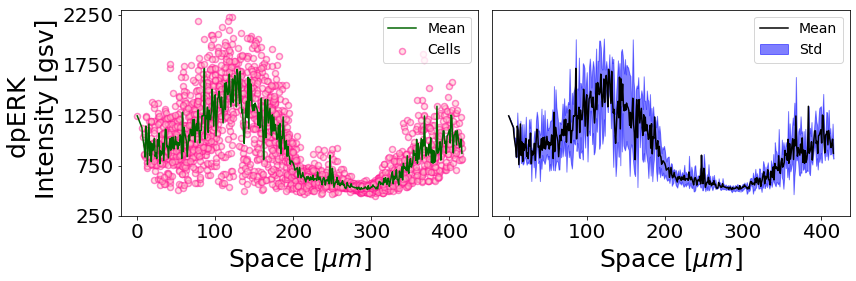

In [383]:
plt.figure(figsize=[12,4])
plt.subplot(121)
plt.scatter(projections-np.min(projections), intensity, alpha=0.5, color='pink', edgecolors='deeppink', linewidth=1.5, label='Cells')
plt.plot(np.unique(projections)-np.min(projections), mean_intensity, color='darkgreen', label='Mean')

plt.legend(fontsize=14)
plt.xticks(np.arange(0,500,100), fontsize=20)
plt.yticks(np.arange(250,2500,500),fontsize=20)
plt.xlabel('Space [$\mu m$]', fontsize=25)
plt.ylabel('dpERK \n Intensity [gsv]', fontsize=25)
plt.ylim([250,2300])

plt.subplot(122)
plt.plot(np.unique(projections)-np.min(projections), mean_intensity, color='black', label='Mean')
plt.fill_between(np.unique(projections)-np.min(projections), mean_intensity-std_intensity,\
                 mean_intensity+std_intensity, alpha = 0.5, color='blue', label='Std')

plt.legend(fontsize=14)
plt.xticks(np.arange(0,500,100), fontsize=20)
plt.yticks([])
plt.xlabel('Space [$\mu m$]', fontsize=25)
plt.ylim([250,2300])

plt.tight_layout()
plt.show()

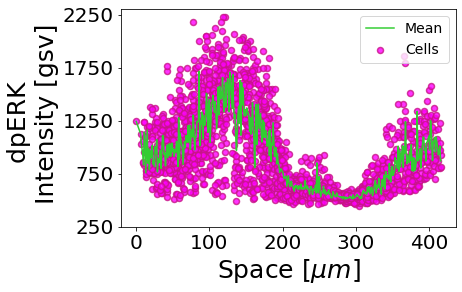

In [384]:
plt.figure(figsize=[6,4])
plt.scatter(projections-np.min(projections), intensity, alpha=0.8, color='magenta', edgecolors='mediumvioletred', linewidth=1.5, label='Cells')
plt.plot(np.unique(projections)-np.min(projections), mean_intensity, color='limegreen', label='Mean')

plt.legend(fontsize=14)
plt.xticks(np.arange(0,500,100), fontsize=20)
plt.yticks(np.arange(250,2500,500),fontsize=20)
plt.xlabel('Space [$\mu m$]', fontsize=25)
plt.ylabel('dpERK \n Intensity [gsv]', fontsize=25)
plt.ylim([250,2300])

plt.show()

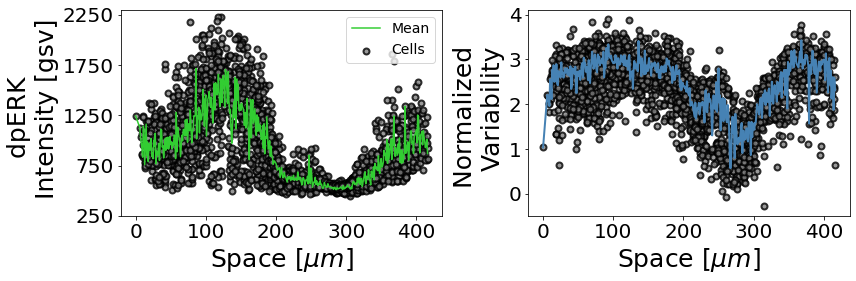

In [420]:
plt.figure(figsize=[12,4])

plt.subplot(121)
plt.scatter(projections-np.min(projections), intensity, alpha=0.8, color='grey', edgecolors='black', linewidth=2, label='Cells')
plt.plot(np.unique(projections)-np.min(projections), mean_intensity, color='limegreen', label='Mean')

plt.legend(fontsize=14)
plt.xticks(np.arange(0,500,100), fontsize=20)
plt.yticks(np.arange(250,2500,500),fontsize=20)
plt.xlabel('Space [$\mu m$]', fontsize=25)
plt.ylabel('dpERK \n Intensity [gsv]', fontsize=25)
plt.ylim([250,2300])

plt.subplot(122)
plt.scatter(projections-min(projections), np.log10(cell_norm_variability),alpha=0.8,\
           color='grey', edgecolors='black', linewidths=2)
plt.plot(np.unique(projections)-min(projections), np.log10(mean_cell_norm_variability),\
         color='steelblue',linewidth=2, alpha=1)

plt.xlabel('Space [$\mu m$]', fontsize=25)
plt.ylabel('Normalized \n Variability', fontsize=25)
plt.xticks(np.arange(0,500,100), fontsize=20)
plt.yticks(fontsize=20)

plt.tight_layout()
plt.show()

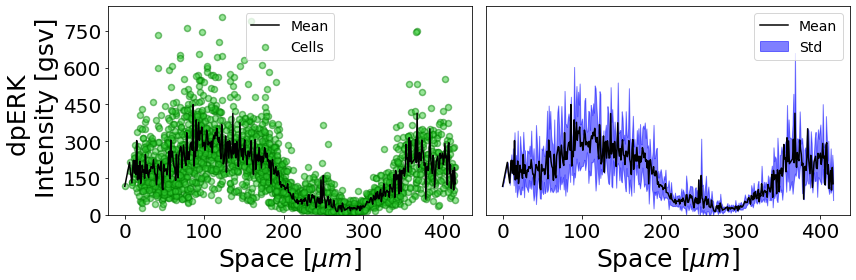

In [386]:
plt.figure(figsize=[12,4])
plt.subplot(121)
plt.scatter(projections-np.min(projections), cell_variability, alpha=0.5, color='limegreen', edgecolors='green', linewidth=1.5, label='Cells')
plt.plot(np.unique(projections)-np.min(projections), mean_cell_variability, color='black', label='Mean')

plt.legend(fontsize=14)
plt.xticks(np.arange(0,500,100), fontsize=20)
plt.yticks(np.arange(0,900,150),fontsize=20)
plt.xlabel('Space [$\mu m$]', fontsize=25)
plt.ylabel('dpERK \n Intensity [gsv]', fontsize=25)
plt.ylim([0,850])

plt.subplot(122)
plt.plot(np.unique(projections)-np.min(projections), mean_cell_variability, color='black', label='Mean')
plt.fill_between(np.unique(projections)-np.min(projections), mean_cell_variability-std_cell_variability,\
                 mean_cell_variability+std_cell_variability, alpha = 0.5, color='blue', label='Std')

plt.legend(fontsize=14)
plt.xticks(np.arange(0,500,100), fontsize=20)
plt.yticks([])
plt.xlabel('Space [$\mu m$]', fontsize=25)
plt.ylim([0,850])

plt.tight_layout()
plt.show()

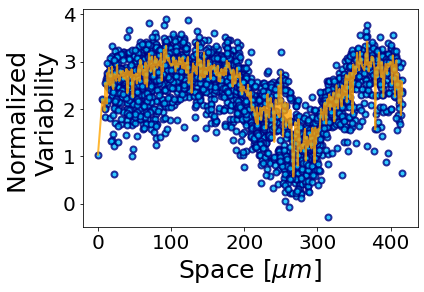

In [387]:
plt.figure(figsize=[6,4])
plt.scatter(projections-min(projections), np.log10(cell_norm_variability),alpha=0.8,\
           color='deepskyblue', edgecolors='navy', linewidths=2)
plt.plot(np.unique(projections)-min(projections), np.log10(mean_cell_norm_variability),\
         color='orange',linewidth=2, alpha=0.8)

plt.xlabel('Space [$\mu m$]', fontsize=25)
plt.ylabel('Normalized \n Variability', fontsize=25)
plt.xticks(np.arange(0,500,100), fontsize=20)
plt.yticks(fontsize=20)

plt.show()

In [ ]:
### Check fano factor

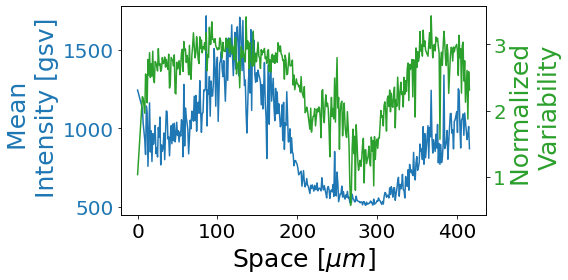

In [422]:
fig, ax1 = plt.subplots(figsize=[8,4])

color = 'tab:blue'
ax1.set_xlabel('Space [$\mu m$]', fontsize=25)
ax1.set_ylabel('Mean \n Intensity [gsv]', color=color, fontsize=25)
ax1.plot(np.unique(projections)-np.min(projections), mean_intensity, color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize=20)
ax1.tick_params(axis='x', labelsize=20) 

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('Normalized \n Variability', color=color, fontsize=25)  # we already handled the x-label with ax1
ax2.plot(np.unique(projections)-np.min(projections), np.log10(mean_cell_norm_variability), color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize=20)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()



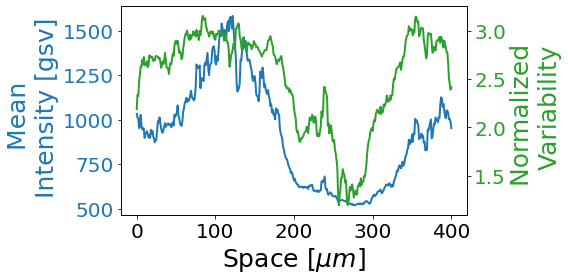

In [423]:
np.convolve(x, np.ones(N)/N, mode='valid')

fig, ax1 = plt.subplots(figsize=[8,4])
N = 5
color = 'tab:blue'
ax1.set_xlabel('Space [$\mu m$]', fontsize=25)
ax1.set_ylabel('Mean \n Intensity [gsv]', color=color, fontsize=25)
ax1.plot(np.convolve(mean_intensity, np.ones(N)/N, mode='valid'), color=color, linewidth=2)
ax1.tick_params(axis='y', labelcolor=color, labelsize=20)
ax1.tick_params(axis='x', labelsize=20) 

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('Normalized \n Variability', color=color, fontsize=25)  # we already handled the x-label with ax1
ax2.plot(np.log10(np.convolve(mean_cell_norm_variability, np.ones(N)/N, mode='valid')), color=color, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color, labelsize=20)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()




In [450]:
np.unique(projections)

405

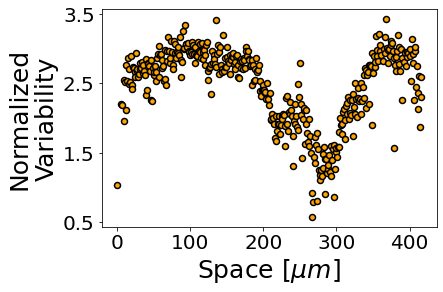

In [455]:
plt.scatter(np.unique(projections)-np.min(np.unique(projections)),np.log10(mean_cell_norm_variability), color='orange', linewidths=1.5, edgecolors='black')
plt.xticks(np.arange(0,500,100), fontsize=20)
plt.yticks(np.arange(0.5,4,1), fontsize=20)
plt.xlabel('Space [$\mu m$]', fontsize=25)
plt.ylabel('Normalized\nVariability', fontsize=25)

plt.show()

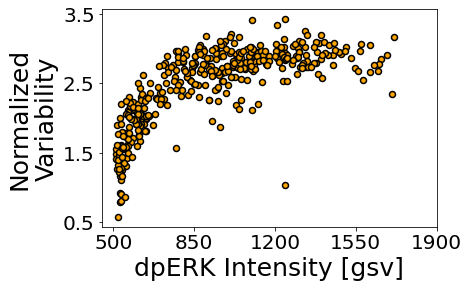

In [454]:
plt.scatter(mean_intensity, np.log10(mean_cell_norm_variability), color='orange', linewidths=1.5, edgecolors='black')
plt.xticks(np.arange(500,2000,350), fontsize=20)
plt.yticks(np.arange(0.5,4,1), fontsize=20)
plt.xlabel('dpERK Intensity [gsv]', fontsize=25)
plt.ylabel('Normalized\nVariability', fontsize=25)

plt.show()

## Tissue level dynamics

Max Projection of the dpERK stain 
2020-11-20, position 1: Planes 55-125 for the max projection
width of the LOI: 80 pixels


In [431]:
dperk_path = pd.read_csv('20201120_151157_98/dpERKProfile-MaxProj.csv')
dperk_path.head()

,Distance_(micrometer),Gray_Value
0,0,975.269
1,1,978.638
2,2,982.774
3,3,983.990
4,4,990.102


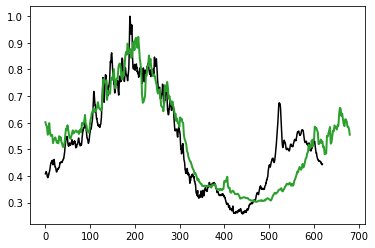

In [444]:
space_len = len(np.convolve(mean_intensity, np.ones(N)/N, mode='valid'))
plt.plot(dperk_path['Distance_(micrometer)']*x_pixel, dperk_path['Gray_Value']/np.max(dperk_path['Gray_Value']), color='black')
plt.plot(np.arange(space_len)*1.7, np.convolve(mean_intensity, np.ones(N)/N, mode='valid')/np.max(mean_intensity), color=color, linewidth=2)



### Adjacency Matrix

Now we are going to build the adjacency matrix:

$S=1-\frac{d}{\epsilon}$

Where $\epsilon$ is the maximum distance ($d_{max}$).

In [ ]:
# From the dist matrix we convert it into a similarity matrix
adj_matrix = (1-dist_matrix/epsilon)*mask



plt.imshow(adj_matrix, vmax=0.01)
plt.colorbar()

### Graph Fourier Transform

In [ ]:
graph = pygsp.graphs.Graph(adj_matrix, lap_type='normalized')

In [ ]:
graph.compute_fourier_basis()

In [ ]:
intensity_rand = np.random.permutation(intensity)
plt.plot(graph.e[1:],graph.gft(intensity)[1:]**2, linewidth=1)
plt.plot(graph.e[1:],graph.gft(intensity_rand)[1:]**2, linewidth=1)

plt.xlim([0,0.1])

In [ ]:
plt.scatter(x_p,y_p,c=graph.U[:,4])

In [ ]:
plt.scatter(x_p, y_p, c=intensity, alpha=0.5, cmap='jet')